In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from mtcnn import MTCNN

In [ ]:
train = pd.read_csv("data/train.csv")
train.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [ ]:
options = ["face_with_mask", "face_no_mask"]
train = train[train["classname"].isin(options)].reset_index(drop=True)
train.sort_values("name", axis=0, inplace=True)

<BarContainer object of 2 artists>

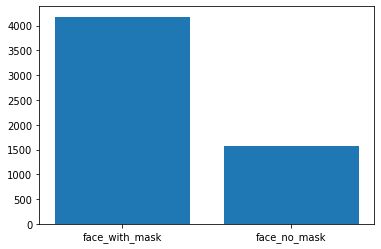

In [ ]:
x_axis_val = ["face_with_mask", "face_no_mask"]
y_axis_val = train.classname.value_counts()
plt.bar(x_axis_val, y_axis_val)

In [ ]:
images_file_path = "data/images/"
image_filenames = os.listdir(images_file_path)
print(image_filenames[:5])

['0175.jpg', '0064.jpg', '0041.jpg', '0206.jpg', '0066.jpg']


In [ ]:

sample_image_name = train.iloc[0]["name"]
sample_image_file_path = images_file_path + sample_image_name

sel_df = train[train["name"] == sample_image_name]

bboxes = sel_df[["x1", "x2", "y1", "y2"]].values.tolist()

fig, ax = plt.subplots()

img = plt.imread(sample_image_file_path)

ax.imshow(img)

for box in bboxes:
    x1, x2, y1, y2 = box

    xy = (x1, x2)

    width = y1 - x1

    height = y2 - x2
    rect = patches.Rectangle(
        xy,
        width,
        height,
        linewidth=2,
        edgecolor="r",
        facecolor="none",
    )
    ax.add_patch(rect)

In [ ]:
mg_size = 50
data = []
for index, row in train.iterrows():

    name, x1, x2, y1, y2, classname = row.values

    full_file_path = images_file_path + name

    img_array = cv2.imread(full_file_path, cv2.IMREAD_GRAYSCALE)

    crop_image = img_array[x2:y2, x1:y1]

    new_img_array = cv2.resize(crop_image, (img_size, img_size))

    data.append([new_img_array, classname])

plt.imshow(data[0][0], cmap="gray")

In [ ]:
x = []
y = []
for features, labels in data:
    x.append(features)
    y.append(labels)

In [ ]:
x = np.array(x).reshape(-1, 50, 50, 1)
x = normalize(x, axis=1)

lbl = LabelEncoder()
y = lbl.fit_transform(y)

y = to_categorical(y)

In [ ]:
input_img_shape = x.shape[1:]
print(input_img_shape)


In [ ]:

model = Sequential()

model.add(
    Conv2D(
        filters=100,
        kernel_size=(3, 3),
        use_bias=True,
        input_shape=input_img_shape,
        activation="relu",
        strides=2,
    )
)

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), use_bias=True, activation="relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(50, activation="relu"))

model.add(Dropout(0.2))

model.add(Dense(2, activation="softmax"))

model.summary()

In [ ]:

opt = Adam(lr=1e-3, decay=1e-5)

model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

model.fit(x, y, epochs=30, batch_size=5)

In [ ]:

test_image_file_path = "sample_test_images/0001.jpg"

img = plt.imread(test_image_file_path)

plt.imshow(img)

In [ ]:

detector = MTCNN()

faces = detector.detect_faces(img)
print(faces)


In [ ]:

img_array = cv2.imread(test_image_file_path, cv2.IMREAD_GRAYSCALE)

detector = MTCNN()

faces = detector.detect_faces(img)

x1, x2, width, height = faces[0]["box"]

crop_image = img_array[x2 : x2 + height, x1 : x1 + width]

new_img_array = cv2.resize(crop_image, (img_size, img_size))

plt.imshow(new_img_array, cmap="gray")

In [ ]:

x = new_img_array.reshape(-1, 50, 50, 1)

x = normalize(x, axis=1)

In [ ]:
prediction = model.predict(x)
print(prediction)

In [ ]:

np.argmax(prediction)